# Using word Embedding

In [1]:
import keras

keras.__version__

Using TensorFlow backend.


'2.2.4'

In [2]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)

In [9]:
from keras.datasets import imdb
from keras import preprocessing
import numpy as np

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words
# (among top max_features most common words)
maxlen = 20

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

# restore np.load for future normal usage
np.load = np_load_old

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer,
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
model.summary()

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_3 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________



Train on 20000 samples, validate on 5000 samples
Epoch 1/10





20000/20000 [==============================] - 3s 128us/step - loss: 0.6759 - acc: 0.6045 - val_loss: 0.6398 - val_acc: 0.6810
Epoch 2/10
20000/20000 [==============================] - 2s 105us/step - loss: 0.5658 - acc: 0.7423 - val_loss: 0.5468 - val_acc: 0.7200
Epoch 3/10
20000/20000 [==============================] - 2s 96us/ste

## Using pre-trained word embeddings

### Download the IMDB data as raw text

In [16]:
import os

imdb_dir = "./aclImdb"
train_dir = os.path.join(imdb_dir, "train")

labels = []
texts = []

for label_type in ["neg", "pos"]:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == ".txt":
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == "neg":
                labels.append(0)
            else:
                labels.append(1)

## Tokenize the data

In [17]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 200  # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print("Shape of data tensor:", data.shape)
print("Shape of label tensor:", labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples : training_samples + validation_samples]
y_val = labels[training_samples : training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


## Download the GloVe word embeddings

## Pre-process the embeddings

In [18]:
glove_dir = "./glove.6B"

embeddings_index = {}
f = open(os.path.join(glove_dir, "glove.6B.100d.txt"), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [19]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

### Define a model

In [20]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### Load the GloVe embeddings in the model

In [21]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

### Train and evaluate

In [22]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
history = model.fit(
    x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val)
)
model.save_weights("pre_trained_glove_model.h5")

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 2s 9ms/step - loss: 1.6330 - acc: 0.5250 - val_loss: 0.7130 - val_acc: 0.5100
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.7565 - acc: 0.5800 - val_loss: 0.6910 - val_acc: 0.5418
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.5958 - acc: 0.6950 - val_loss: 1.1238 - val_acc: 0.4936
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.5375 - acc: 0.7200 - val_loss: 0.7009 - val_acc: 0.5524
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4669 - acc: 0.7600 - val_loss: 0.6866 - val_acc: 0.5674
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.2583 - acc: 0.9350 - val_loss: 0.7346 - val_acc: 0.5444
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.1667 - acc: 0.9650 - val_loss: 1.3944 - val_acc: 0.4965
Epoch 8/10
200/200 [========

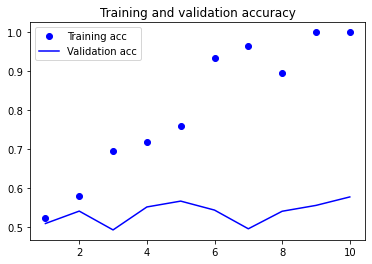

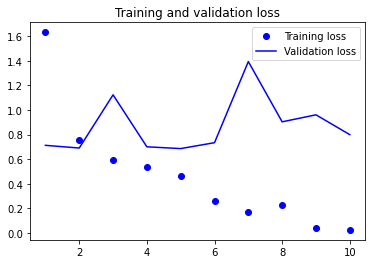

In [23]:
import matplotlib.pyplot as plt

acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [24]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.summary()

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
history = model.fit(
    x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val)
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 2s 9ms/step - loss: 0.6949 - acc: 0.4650 - val_loss: 0.6955 - val_acc: 0.5156
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 0.4956 - a

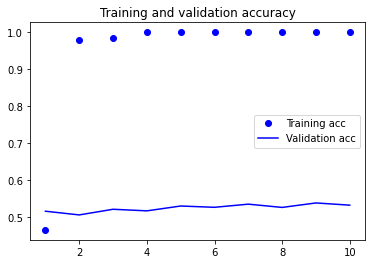

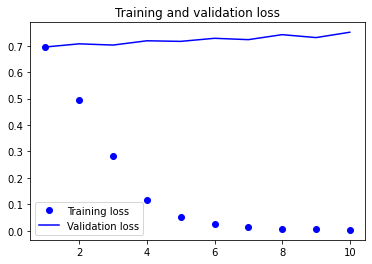

In [25]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [27]:
test_dir = os.path.join(imdb_dir, "test")

labels = []
texts = []

for label_type in ["neg", "pos"]:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == ".txt":
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == "neg":
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [28]:
model.load_weights("pre_trained_glove_model.h5")
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 69us/step


[0.8021864112854004, 0.57712]